In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

In [2]:
cwt = pickle.load( open( "wvlt.p", "rb" ) )

In [3]:
cwt.shape

(95, 51, 2500)

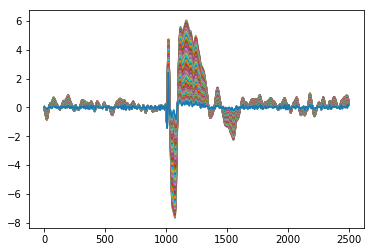

In [71]:
plt.plot(cwt[0, :, :].T)

In [9]:
2500/50

50.0

In [7]:
# Get the phases:
cwt_phases = np.angle(cwt)

In [14]:
import time
import pdb

In [24]:
# Calculate the phase correlation matrix:
phase_corr = np.zeros((95, 95, 51, 50))
for i, ref_idx in enumerate(np.arange(95)):
    start = time.time()
    for j in range(phase_corr.shape[1]):
        for k in range(phase_corr.shape[2]):
            for l in range(phase_corr.shape[3]):
                x1 = cwt_phases[ref_idx,  k, l*50:(l+1)*50]
                x2 = cwt_phases[j, k, l*50:(l+1)*50]
                delta_phi = np.mod(x1 - x2, 2 * np.pi)
                phase_corr[i, j, k, l] = 1/50 * np.abs(np.sum(np.exp(1j*delta_phi)))
    print(time.time() - start)

3.1147186756134033
3.093773365020752
3.113725185394287
3.0802924633026123
3.0897603034973145
3.0802931785583496
3.0878050327301025
3.114229679107666
3.0972728729248047
3.0448927879333496
3.0628468990325928
3.0568597316741943
3.0793063640594482
3.0708117485046387
3.0673270225524902
3.067338228225708
3.081794023513794
3.073828935623169
3.072831392288208
3.0793044567108154
3.125185012817383
3.106738567352295
3.0987486839294434
3.085782289505005
3.1042513847351074
3.0847854614257812
3.153125524520874
3.086296796798706
3.0818047523498535
3.087789297103882
3.0977392196655273
3.065870761871338
3.075819730758667
3.065333843231201
3.078317880630493
3.089789867401123
3.0877773761749268
3.055384635925293
3.0683517456054688
3.0792958736419678
3.072819709777832
3.098761558532715
3.079310655593872
3.0852913856506348
3.078789472579956
3.0848028659820557
3.0688514709472656
3.070821762084961
3.089784860610962
3.0563783645629883
3.0718328952789307
3.089279890060425
3.0857810974121094
3.070814609527588
3

In [39]:
f = h5py.File('RM1_p45_day4_trial_1_PAINT.mat', 'r')
phi = np.zeros(f['cfg_PAINT_cond']['chanlocs']['sph_phi'].size)
theta = np.zeros(phi.shape)
radius = np.zeros(phi.shape)
for i, ref in enumerate(f['cfg_PAINT_cond']['chanlocs']['sph_phi']):
    phi_ref = ref[0]
    theta_ref = f['cfg_PAINT_cond']['chanlocs']['sph_theta'][i][0]
    radius_ref = f['cfg_PAINT_cond']['chanlocs']['sph_radius'][i][0]
    
    phi[i] = f[phi_ref][0][0] * np.pi/180
    theta[i] = f[theta_ref][0][0] * np.pi/180
    radius[i] = f[radius_ref][0][0]
    
# Convert from spherical to Cartesian coordinates
x = radius * np.sin(phi) * np.cos(theta)
y = radius * np.sin(phi) * np.sin(theta)
z = radius * np.cos(phi)

# Stereographic projection
X = x/(1 -z)
Y = y/(1 - z)

In [36]:
times = np.linspace(-1000, 1500, 51)[:-1]

In [37]:
times

array([-1000.,  -950.,  -900.,  -850.,  -800.,  -750.,  -700.,  -650.,
        -600.,  -550.,  -500.,  -450.,  -400.,  -350.,  -300.,  -250.,
        -200.,  -150.,  -100.,   -50.,     0.,    50.,   100.,   150.,
         200.,   250.,   300.,   350.,   400.,   450.,   500.,   550.,
         600.,   650.,   700.,   750.,   800.,   850.,   900.,   950.,
        1000.,  1050.,  1100.,  1150.,  1200.,  1250.,  1300.,  1350.,
        1400.,  1450.])

In [48]:
ref_point = 83

# Average into cannonical bands

# Divide frequencies into cannonical bands
freq = f['cfg_PAINT_cond']['ERSPfreq'][:]
theta_band = freq[0:4]
alpha_band = freq[4:8]
beta_band = freq[8:26]
gamma_band = freq[26::]

# Average correlations for a sample point over the freqeuncy bands
theta_corr = np.mean(phase_corr[ref_point, :, 0:4, :], axis = 1)
alpha_corr = np.mean(phase_corr[ref_point, :, 4:8, :], axis = 1)
beta_corr = np.mean(phase_corr[ref_point, :, 8:26, :], axis = 1)
gamma_corr = np.mean(phase_corr[ref_point, :, 26::, :], axis = 1)

minval = 0
maxval = 1

np.arange(-1.5)

for i, t in enumerate(times):

    theta_val = theta_corr[:, i]
    alpha_val = alpha_corr[:, i]
    beta_val = beta_corr[:, i]
    gamma_val = gamma_corr[:, i]

    
    # Plotting
    fig = plt.figure(figsize = (15, 15))
    
    cmap = plt.get_cmap('RdGy')

    # Create a setof triangles that define the convex hull of x y points
    triang = mtri.Triangulation(x, y)

    # Refine the z coordinates to produce a finer mesh
    refiner = mtri.UniformTriRefiner(triang)
    tri_refi, z_refi = refiner.refine_field(z, subdiv = 3)   
##########################################################################################################
    ax = fig.add_subplot(2, 2, 1, projection = '3d')
    # Do the same for the scalar values to be plotted
    refiner = mtri.UniformTriRefiner(triang)
    tri_refi, vals_refi = refiner.refine_field(theta_val)

    # Take the value of a triangle to be the average of its values at its verticies
    colors = np.mean(vals_refi[tri_refi.triangles], axis = 1)   
    # Plots the triangular mesh formed from the (x, y, z) coordinates
    collec = ax.plot_trisurf(tri_refi, z_refi, cmap=cmap, shade=False, linewidth=0., edgecolor='none', antialiased=False)
    # Sets the colorscale according to the values to be plotted
    collec.set_array(colors)
    # Adjust the scaling so the colorscale fits the maximum and minimum responses
    collec.set_clim(vmin=minval, vmax=maxval)

    ax.view_init(azim=0, elev=90)
    ax.set_title('Theta Band', fontsize = 16)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.dist = 7
    
##############################################################################################################    
    ax = fig.add_subplot(2, 2, 2, projection = '3d')
    refiner = mtri.UniformTriRefiner(triang)
    tri_refi, vals_refi = refiner.refine_field(alpha_val)
    colors = np.mean(vals_refi[tri_refi.triangles], axis = 1)       
    # Plots the triangular mesh formed from the (x, y, z) coordinates
    collec = ax.plot_trisurf(tri_refi, z_refi, cmap=cmap, shade=False, linewidth=0., edgecolor='none', antialiased=False)
    # Sets the colorscale according to the values to be plotted
    collec.set_array(colors)
    # Adjust the scaling so the colorscale fits the maximum and minimum responses
    collec.set_clim(vmin=minval, vmax=maxval)
    # Top down view (can adjust azimuthal angle and elevation angle to get arbitrary views)

    ax.view_init(azim=0, elev=90)
    ax.set_title('Alpha Band', fontsize = 16)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.dist = 7

###################################################################################################################    
    ax = fig.add_subplot(2, 2, 3, projection = '3d')
    refiner = mtri.UniformTriRefiner(triang)
    tri_refi, vals_refi = refiner.refine_field(beta_val)
    colors = np.mean(vals_refi[tri_refi.triangles], axis = 1)       
    
    # Plots the triangular mesh formed from the (x, y, z) coordinates
    collec = ax.plot_trisurf(tri_refi, z_refi, cmap=cmap, shade=False, linewidth=0., edgecolor='none', antialiased=False)
    # Sets the colorscale according to the values to be plotted
    collec.set_array(colors)
    # Adjust the scaling so the colorscale fits the maximum and minimum responses
    collec.set_clim(vmin=minval, vmax=maxval)
    # Top down view (can adjust azimuthal angle and elevation angle to get arbitrary views)

    ax.view_init(azim=0, elev=90)
    ax.set_title('Beta Band', fontsize = 16)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.dist = 7

##########################################################################################################################    
    ax = fig.add_subplot(2, 2, 4, projection = '3d')
    refiner = mtri.UniformTriRefiner(triang)
    tri_refi, vals_refi = refiner.refine_field(gamma_val)
    colors = np.mean(vals_refi[tri_refi.triangles], axis = 1)       

    # Plots the triangular mesh formed from the (x, y, z) coordinates
    collec = ax.plot_trisurf(tri_refi, z_refi, cmap=cmap, shade=False, linewidth=0., edgecolor='none', antialiased=False)
    # Sets the colorscale according to the values to be plotted
    collec.set_array(colors)
    # Adjust the scaling so the colorscale fits the maximum and minimum responses
    collec.set_clim(vmin=minval, vmax=maxval)
    # Top down view (can adjust azimuthal angle and elevation angle to get arbitrary views)

    ax.view_init(azim=0, elev=90)
    ax.set_title('Gamma Band', fontsize = 16)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.dist = 7
    fig.subplots_adjust(hspace = 0, wspace = 0, left = 0, right = 1, top = 0.9, bottom = 0)
#    plt.tight_layout()
    cax = fig.add_axes([0.485, 0.055, 0.02, 0.35])
    fig.colorbar(collec, shrink = 0.5, cax = cax)
    fig.suptitle('Mean Phase Coherence, t = %.1f ms' % t, fontsize = 20)
    plt.savefig('figs/phasesync/ref83_%d.png' % i)
    plt.close()
    print(time.time() - start)
    

1439.4162936210632
1443.4106140136719
1446.5891149044037
1449.8075098991394
1452.9640700817108
1456.1445653438568
1459.257244348526
1462.458683013916
1465.6700959205627
1468.796736240387
1471.94731259346
1475.1188321113586
1478.269408941269
1481.4259684085846
1484.6523416042328
1487.9146189689636
1491.2108056545258
1494.4421656131744
1497.5079681873322
1500.7483043670654
1504.1561918258667
1507.309760093689
1510.6588053703308
1513.883184671402
1516.9739203453064
1520.2631273269653
1523.339899301529
1526.8894097805023
1529.9980969429016
1533.4269280433655
1537.04625082016
1540.3992855548859
1543.5059790611267
1546.8320863246918
1549.9337923526764
1553.519206047058
1557.1086082458496
1561.2605075836182
1564.9057614803314
1568.8746819496155
1573.5092911720276
1577.0119245052338
1580.708042383194
1585.0334765911102
1588.7734770774841
1592.3249814510345
1596.2365221977234
1599.2783889770508
1602.375108718872
1605.7929701805115


In [49]:
theta_corr.shape

(95, 50)

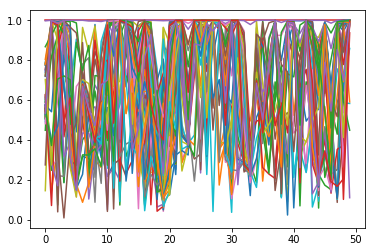

In [51]:
plt.plot(theta_corr.T)

In [52]:
phase_corr.shape

(95, 95, 51, 50)

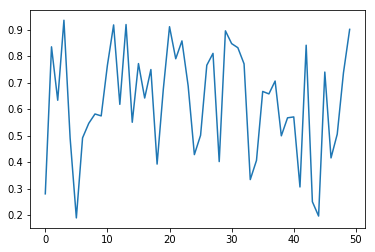

In [56]:
plt.plot(np.mean(phase_corr[83, 25, :, :], axis = 0))

In [64]:
# Calculate the phase correlation matrix with window size 10:
phase_corr2 = np.zeros((95, 95, 51, 250))
for i, ref_idx in enumerate(np.arange(95)):
    start = time.time()
    for j in range(phase_corr2.shape[1]):
        for k in range(phase_corr2.shape[2]):
            for l in range(phase_corr2.shape[3]):
                x1 = cwt_phases[ref_idx,  k, l*10:(l+1)*10]
                x2 = cwt_phases[j, k, l*10:(l+1)*10]
                delta_phi = np.mod(x1 - x2, 2 * np.pi)
                phase_corr2[i, j, k, l] = 1/10 * np.abs(np.sum(np.exp(1j*delta_phi)))
    print(time.time() - start)

12.260218858718872
12.216335535049438
12.361947059631348
12.16646933555603
12.052773237228394
11.982959985733032
11.73861312866211
11.90716290473938
11.775514602661133
11.857295989990234
11.668799638748169
11.794464349746704
11.749584197998047
12.103637218475342
12.240272045135498
12.092666387557983
12.1146080493927
12.19539189338684
11.862282991409302
12.076709508895874
12.133556842803955
11.841339111328125
12.073717594146729
12.300112247467041
12.196389198303223
12.007893323898315
12.094661951065063
12.606292724609375
12.09067177772522
12.069728374481201
12.011882305145264
12.036815881729126
12.588342666625977
12.159487009048462
12.375909328460693
12.129567623138428
12.14353084564209
11.891205549240112
11.739610433578491
12.229301691055298
12.054767847061157
11.885221242904663
12.114607810974121
12.138543605804443
11.929104089736938
12.142533540725708
12.191402673721313
12.056763172149658
12.211349248886108
11.898186206817627
12.395856857299805
12.03182864189148
12.000911951065063
12

In [61]:
phase_corr2.shape

(1, 95, 51, 250)

In [77]:
freqs[25]

NameError: name 'freqs' is not defined

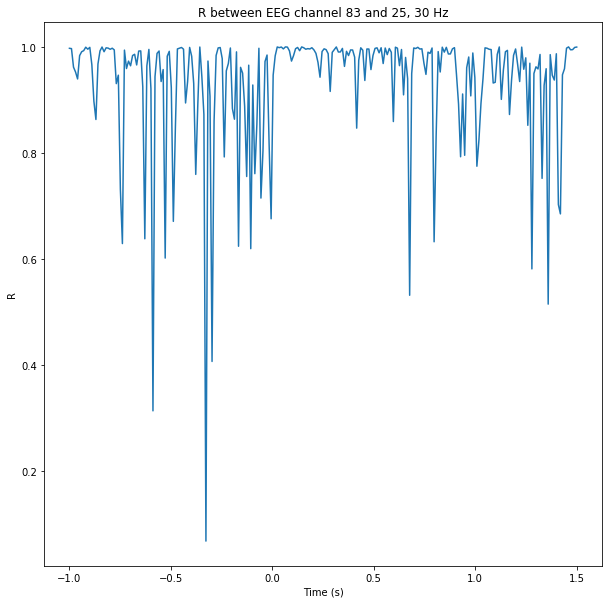

In [79]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(np.linspace(-1, 1.5, 250), phase_corr2[0, 25, 25, :].T)
ax.set_title('R between EEG channel 83 and 25, 30 Hz')
ax.set_ylabel('R')
ax.set_xlabel('Time (s)')
plt.savefig('figs/psync.png')

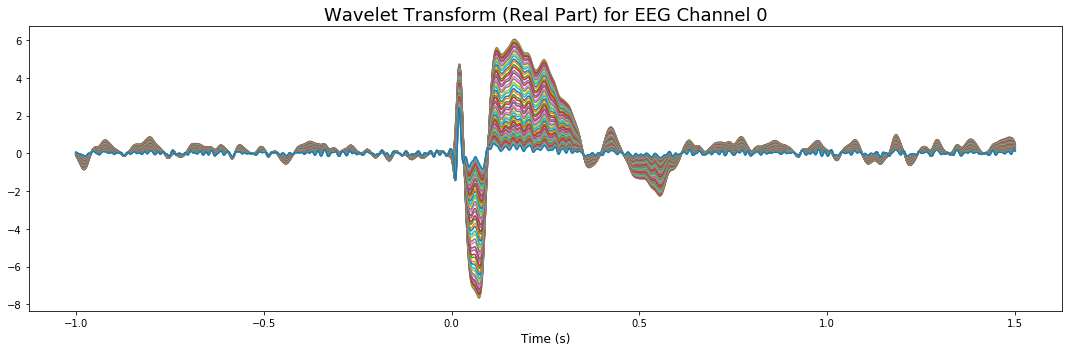

In [73]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(np.linspace(-1, 1.5, 2500), cwt[0, :, :].T)
ax.set_title('Wavelet Transform (Real Part) for EEG Channel 0', fontsize = 18)
ax.set_xlabel('Time (s)', fontsize = 12)
plt.tight_layout()
plt.savefig('figs/wvlt_sample.png')

In [88]:
# Calculate the phase correlation matrix with window size 10:
phase_corr3 = np.zeros((95, 95, 51, 2450))
for i, ref_idx in enumerate([83]):
    start = time.time()
    for j in [25]:
        for k in [25]:
            for l in range(25, 2475):
                x1 = cwt_phases[ref_idx,  k, l - 25:l+25]
                x2 = cwt_phases[j, k, l-25:l+25]
                delta_phi = np.mod(x1 - x2, 2 * np.pi)
                phase_corr3[i, j, k, l - 25] = 1/50 * np.abs(np.sum(np.exp(1j*delta_phi)))
    print(time.time() - start)

0.04089045524597168


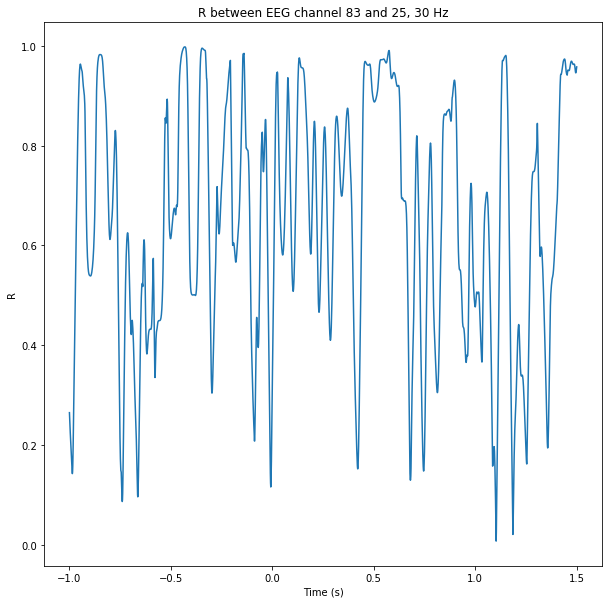

In [89]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(np.linspace(-1, 1.5, 2450), phase_corr3[0, 25, 25, :].T)
ax.set_title('R between EEG channel 83 and 25, 30 Hz')
ax.set_ylabel('R')
ax.set_xlabel('Time (s)')
plt.savefig('figs/psync2.png')

In [90]:
# Calculate the phase correlation matrix with window size 10:
phase_corr4 = np.zeros((95, 95, 51, 2400))
for i, ref_idx in enumerate([83]):
    start = time.time()
    for j in [25]:
        for k in [25]:
            for l in range(50, 2450):
                x1 = cwt_phases[ref_idx,  k, l - 50:l+50]
                x2 = cwt_phases[j, k, l-50:l+50]
                delta_phi = np.mod(x1 - x2, 2 * np.pi)
                phase_corr4[i, j, k, l - 50] = 1/100 * np.abs(np.sum(np.exp(1j*delta_phi)))
    print(time.time() - start)

0.04388284683227539


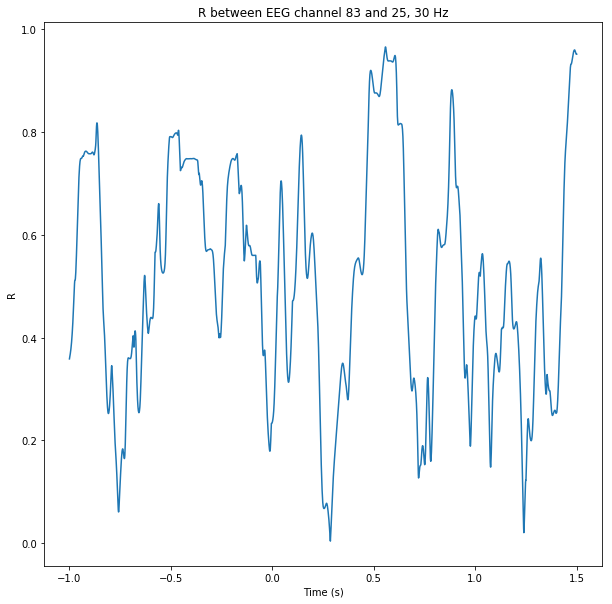

In [93]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(np.linspace(-1, 1.5, 2400), phase_corr4[0, 25, 25, :].T)
ax.set_title('R between EEG channel 83 and 25, 30 Hz')
ax.set_ylabel('R')
ax.set_xlabel('Time (s)')
plt.savefig('figs/psync3.png')

In [94]:
# Calculate the phase correlation matrix with window size 10:
phase_corr5 = np.zeros((95, 95, 51, 2480))
for i, ref_idx in enumerate([83]):
    start = time.time()
    for j in [25]:
        for k in [25]:
            for l in range(10, 2490):
                x1 = cwt_phases[ref_idx,  k, l - 10:l+10]
                x2 = cwt_phases[j, k, l-10:l+10]
                delta_phi = np.mod(x1 - x2, 2 * np.pi)
                phase_corr5[i, j, k, l - 10] = 1/20 * np.abs(np.sum(np.exp(1j*delta_phi)))
    print(time.time() - start)

0.03191518783569336


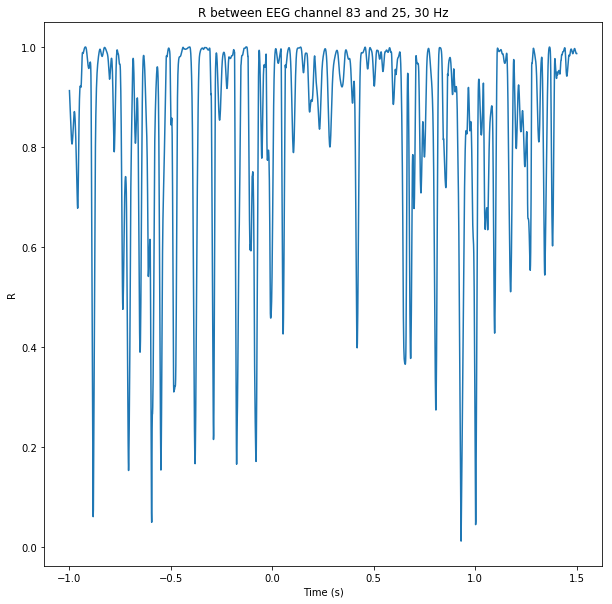

In [96]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(np.linspace(-1, 1.5, 2480), phase_corr5[0, 25, 25, :].T)
ax.set_title('R between EEG channel 83 and 25, 30 Hz')
ax.set_ylabel('R')
ax.set_xlabel('Time (s)')
plt.savefig('figs/psync4.png')